In [1]:
import pandas as pd
import os
import numpy as np
from Evaluate import *
import matplotlib.pyplot as plt

In [16]:

def get_precision(tp, fp):
    try:
        precision = tp/(tp + fp)
    except ZeroDivisionError:
        precision = 0.0

    return precision

def get_recall(tp, fn):
    try:
        recall = tp/(tp + fn)
    except ZeroDivisionError:
        recall = 0.0

    return recall

def get_f1score(precisions, recalls):
    f1 = np.divide(2 * (np.array(precisions) * np.array(recalls)), (np.array(precisions) + np.array(recalls)))

    return f1


def EvaluateResults(dirPred, pathPred, dirGT, pathGT, env):
    Pred = []
    GT = []

    for file in range(0, len(dirPred)):
        #Each row is: class x_center y_center width height
        with open (pathPred + dirPred[file], "r") as myfile:
            data = myfile.read().split(" ")
            #print(data)
            #print(data[2])
            x_center = float(data[2])
            y_center = float(data[3])
            width = float(data[4])
            height = float(data[5])

            xmin = x_center - width/2
            ymin = y_center - height/2
            xmax = x_center + width/2
            ymax = y_center + height/2

            bboxPred = [xmin, ymin, xmax, ymax]
            Pred.append(bboxPred)


        with open (pathGT + dirGT[file], "r") as valfile:
            dataVal = valfile.read().split(" ")
            x_centerVal = float(dataVal[1])
            y_centerVal = float(dataVal[2])
            widthVal = float(dataVal[3])
            heightVal = float(dataVal[4])

            xminVal = x_centerVal - widthVal/2
            yminVal = y_centerVal - heightVal/2
            xmaxVal = x_centerVal + widthVal/2
            ymaxVal = y_centerVal + heightVal/2

            bboxGT = [xminVal, yminVal, xmaxVal, ymaxVal]
            GT.append(bboxGT)

    IOUs = []
    for i in range(0, len(GT)):
        iou = calc_iou_individual(Pred[i], GT[i])
        IOUs.append(iou)
        print(f'IOU: {iou}')

    sortedIOU = sorted(IOUs)
    
    avgIOU = np.average(IOUs)
    print(f'Average IOU of {env} bboxes: {avgIOU}')
    print(f'Lowest IOU of {env} bboxes: {np.min(IOUs)}')
    print(f'Highest IOU of {env} bboxes: {np.max(IOUs)}')
    print(f'Median IOU of {env} bboxes: {np.median(sortedIOU)}')

    dicts = {}
    resAtIIOU = []
    yaxis = []
    precisionAtIOU = []
    recallAtIOU = []
    f1AtIOU = []

    for i in range(1, 96):
        res = get_single_image_results(gt_boxes=GT, pred_boxes=Pred, iou_thr=i/100)
        
        resAtIIOU.append(res)
        
        precision = get_precision(tp=res.get('true_pos'), fp=res.get('false_pos'))
        recall = get_recall(tp=res.get('true_pos'), fn=res.get('false_neg'))
        f1 = get_f1score(recalls=recall, precisions=precision)
        precisionAtIOU.append(precision)
        recallAtIOU.append(recall)
        f1AtIOU.append(f1)
        yaxis.append(i/100)

        if i >= 50:
            if i%5 == 0:
                pass


        
    
    
    plt.plot(np.arange(0, 0.95, 0.01), precisionAtIOU)
    plt.title(f"Precision at different IOUs: {env}")
    plt.xticks(np.arange(0, 1, 0.1))
    plt.xlabel("IOUs")
    plt.ylabel('Precision')
    plt.show()

    plt.plot(np.arange(0, 0.95, 0.01), recallAtIOU)
    plt.title(f"Recall at different IOUs: {env}")
    plt.xticks(np.arange(0, 1, 0.1))
    plt.xlabel("IOUs")
    plt.ylabel('Recall')
    plt.show()

    plt.plot(precisionAtIOU, recallAtIOU)
    plt.title(f"Precision/Recall curve: {env}")
    plt.xticks(np.arange(0, 1, 0.1))
    plt.xlabel("Precision")
    plt.ylabel('Recall')
    plt.show()

    plt.plot(np.arange(0, 0.95, 0.01), f1AtIOU)
    plt.title(f"F1-score at different IOUs: {env}")
    plt.xticks(np.arange(0, 1, 0.1))
    plt.xlabel("IOUs")
    plt.ylabel('F1-score')
    plt.show()


    return recallAtIOU, precisionAtIOU, f1AtIOU
    

In [15]:

@staticmethod
def CalculateAveragePrecision(rec, prec):
    mrec = []
    mrec.append(0)
    [mrec.append(e) for e in rec]
    mrec.append(1)
    mpre = []
    mpre.append(0)
    [mpre.append(e) for e in prec]
    mpre.append(0)
    for i in range(len(mpre) - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    ii = []
    for i in range(len(mrec) - 1):
        if mrec[1+i] != mrec[i]:
            ii.append(i + 1)
    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
    # return [ap, mpre[1:len(mpre)-1], mrec[1:len(mpre)-1], ii]
    return [ap, mpre[0:len(mpre) - 1], mrec[0:len(mpre) - 1], ii]

@staticmethod
# 11-point interpolated average precision
def ElevenPointInterpolatedAP(rec, prec):
    # def CalculateAveragePrecision2(rec, prec):
    mrec = []
    # mrec.append(0)
    [mrec.append(e) for e in rec]
    # mrec.append(1)
    mpre = []
    # mpre.append(0)
    [mpre.append(e) for e in prec]
    # mpre.append(0)
    recallValues = np.linspace(0, 1, 11)
    recallValues = list(recallValues[::-1])
    rhoInterp = []
    recallValid = []
    # For each recallValues (0, 0.1, 0.2, ... , 1)
    for r in recallValues:
        # Obtain all recall values higher or equal than r
        argGreaterRecalls = np.argwhere(mrec[:] >= r)
        pmax = 0
        # If there are recalls above r
        if argGreaterRecalls.size != 0:
            pmax = max(mpre[argGreaterRecalls.min():])
        recallValid.append(r)
        rhoInterp.append(pmax)
    # By definition AP = sum(max(precision whose recall is above r))/11
    ap = sum(rhoInterp) / 11
    # Generating values for the plot
    rvals = []
    rvals.append(recallValid[0])
    [rvals.append(e) for e in recallValid]
    rvals.append(0)
    pvals = []
    pvals.append(0)
    [pvals.append(e) for e in rhoInterp]
    pvals.append(0)
    # rhoInterp = rhoInterp[::-1]
    cc = []
    for i in range(len(rvals)):
        p = (rvals[i], pvals[i - 1])
        if p not in cc:
            cc.append(p)
        p = (rvals[i], pvals[i])
        if p not in cc:
            cc.append(p)
    recallValues = [i[0] for i in cc]
    rhoInterp = [i[1] for i in cc]
    return [ap, rhoInterp, recallValues, None]

In [8]:
dirCity = os.listdir("..\SegmentEval//CityPred//labels")
pathCity = "..\SegmentEval//CityPred//labels//"

pathValCity = "..\SegmentEval//CityGT//train//labels//"
dirValCity = os.listdir("..\SegmentEval//CityGT//train//labels")

dirHighway = os.listdir("..\SegmentEval//HighwayPred//labels")
pathHighway = "..\SegmentEval//HighwayPred//labels//"

pathValHighway= "..\SegmentEval//HighwayGT//train//labels//"
dirValHighway = os.listdir("..\SegmentEval//HighwayGT//train//labels")

dirPark = os.listdir("..\SegmentEval//ParkPred//labels")
pathPark = "..\SegmentEval//ParkPred//labels//"

pathValPark = "..\SegmentEval//ParkGT//train//labels//"
dirValPark = os.listdir("..\SegmentEval//ParkGT//train//labels")

IOU: 0.9449922395690677
IOU: 0.7589724902336286
IOU: 0.38028198981545847
IOU: 0.42527710843373495
IOU: 0.4700547110017617
IOU: 0.508835299373592
IOU: 0.4585410000000001
IOU: 0.8758069130769093
IOU: 0.43103298724053885
IOU: 0.4612631578947368
IOU: 0.42701417004048586
IOU: 0.7928081896179675
IOU: 0.6415135416666669
IOU: 0.6011449579831932
IOU: 0.7359728447582979
IOU: 0.7397582142721797
IOU: 0.7040717351518263
IOU: 0.0
IOU: 0.4135405405405405
IOU: 0.7833327293154065
IOU: 0.6931302796981523
IOU: 0.5542294789854102
IOU: 0.7970254316199523
IOU: 0.6343870877173992
IOU: 0.6343051743970148
IOU: 0.5448644472180478
IOU: 0.8013351451848494
IOU: 0.5189390862944161
IOU: 0.7384492600795534
IOU: 0.5493436754176612
IOU: 0.6024840276003067
IOU: 0.7552990277142723
IOU: 0.693106535362578
IOU: 0.43448662029942237
IOU: 0.5110922610177521
IOU: 0.6164906132335424
IOU: 0.646751664620764
IOU: 0.6881376518218624
IOU: 0.8504672897196263
IOU: 0.5135658348430833
IOU: 0.4297727686778515
IOU: 0.6048015563370497
IOU: 

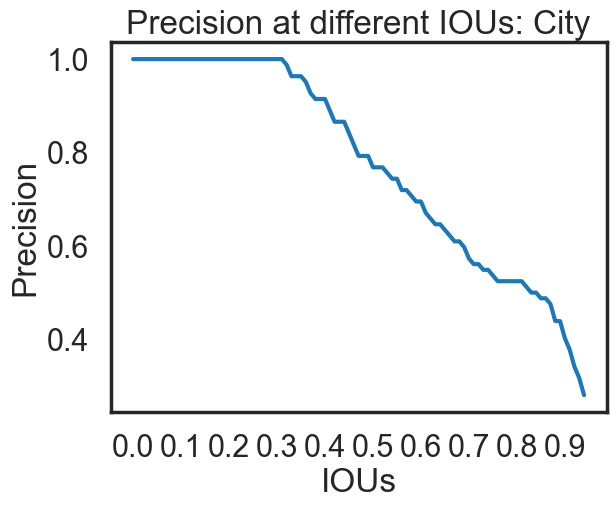

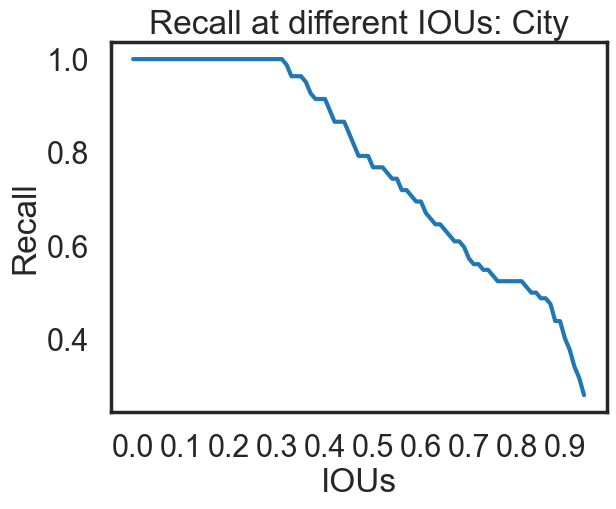

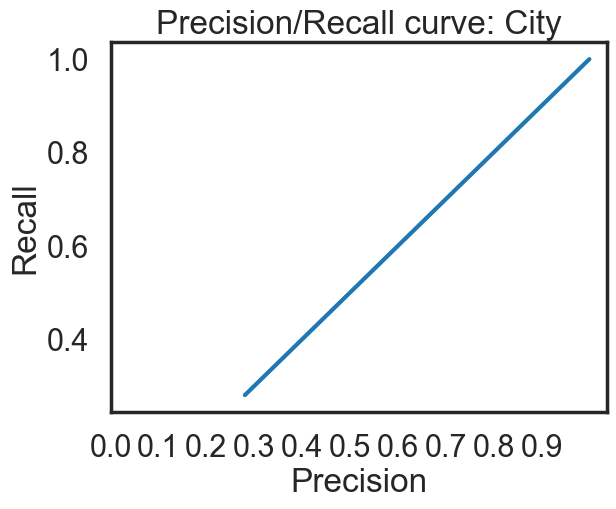

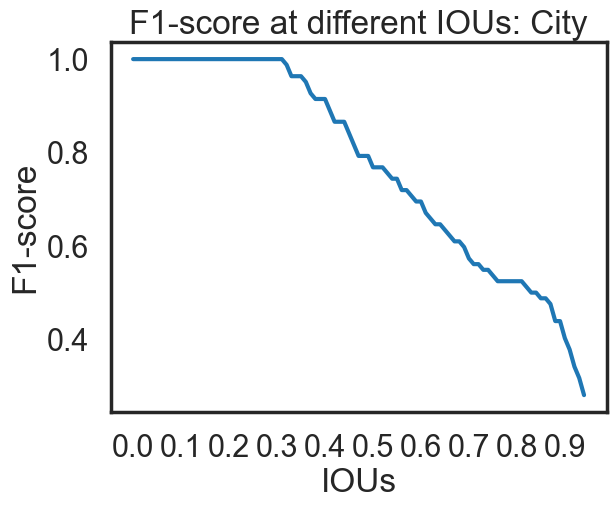

0


In [17]:
recl, prec, f1sc = EvaluateResults(dirCity, pathCity, dirValCity, pathValCity, "City")



avgPrec11point, rhoInterpolation, recallVals, non = ElevenPointInterpolatedAP(rec=recl, prec=prec)
print(np.argmax(avgPrec11point))






In [ ]:
EvaluateResults(dirHighway, pathHighway, dirValHighway, pathValHighway, "Highway")


In [ ]:
EvaluateResults(dirPark, pathPark, dirValPark, pathValPark, "Park")